# Install Library

In [1]:
!pip install transformers evaluate 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/84.0 kB ? eta -:--:--


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/183.9 kB ? eta -:--:--


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.7 MB/s eta 0:00:00


  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2


    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-curand-cu12 10.3.9.90 which is incompatible.


# Import Library

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    DefaultDataCollator,
    AutoModelForQuestionAnswering,
    default_data_collator,
    get_scheduler,
)
from datasets import Dataset, DatasetDict
from accelerate import Accelerator
from tqdm.auto import tqdm
import numpy as np
import collections
import evaluate
import json
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2025-05-03 01:49:38.281155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746236978.474353      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746236978.529948      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

In [3]:
dataset_path = "/kaggle/input/indonesian-version-of-squad"

with open(os.path.join(dataset_path, 'dev-v2.0.json')) as f:
    dev = json.load(f)

with open(os.path.join(dataset_path, 'train-v2.0.json')) as f:
    train = json.load(f)

## Format dataset

In [4]:
def format(content):
    hf_data = []
    for data in content["data"]:
        title = data["title"]
        for paragraph in data["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                fill = {
                    "id": qa["id"],
                    "title": title,
                    "context": context,
                    "question": qa["question"],
                    # "is_impossible": qa["is_impossible"],
                    "answers": {"answer_start": [], "text": []}
                }
                if not qa["is_impossible"]:
                    for answer in qa["answers"]:
                        fill["answers"]["answer_start"].append(answer["answer_start"])
                        fill["answers"]["text"].append(answer["text"])

                hf_data.append(fill)

    return hf_data

In [5]:
train_data = format(train)
dev_data = format(dev)

In [6]:
len(train_data)

130318

In [7]:
len(dev_data)

11858

# Preprocessing

## Remove Unanswerable Question

In [8]:
# def filter_valid_questions(hf_data):
#     filtered_data = []
#     for item in hf_data:
#         if item["is_impossible"]:
#             continue
#         item = {key: value for key, value in item.items() if key != "is_impossible"}
#         filtered_data.append(item)

#     return filtered_data

In [9]:
# filtered_train_data = filter_valid_questions(train_data)
# len(filtered_train_data)

In [10]:
# filtered_dev_data = filter_valid_questions(dev_data)
# len(filtered_dev_data)

# Split Data

In [11]:
train_set, test_set = train_test_split(train_data, test_size=0.1, random_state=42)

In [12]:
train = train_set
dev = dev_data
test = test_set
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Train: 117286
Dev: 11858
Test: 13032


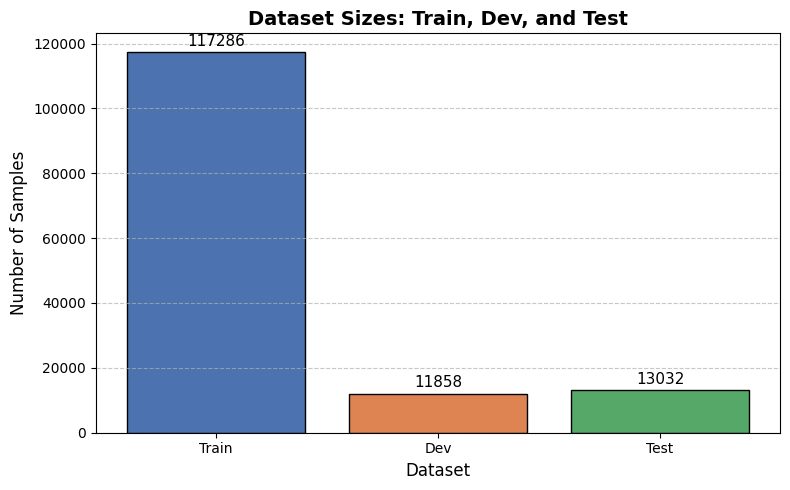

In [13]:
# Data
datasets = ["Train", "Dev", "Test"]
lengths = [len(train), len(dev), len(test)]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(datasets, lengths, color=['#4C72B0', '#DD8452', '#55A868'], edgecolor='black', linewidth=1)

# Labels and title
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Dataset Sizes: Train, Dev, and Test", fontsize=14, weight='bold')

# Show value on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + max(lengths) * 0.01, 
             f"{height}", ha='center', va='bottom', fontsize=11)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tweak layout
plt.tight_layout()

plt.show()


In [14]:
def show_random_data(dataset, num_examples=3):
    assert num_examples <= len(dataset)
    
    picks = random.sample(range(len(dataset)), num_examples)
    sampled_data = [dataset[i] for i in picks]
    df = pd.DataFrame(sampled_data)

    df['answer_start'] = df['answers'].apply(lambda x: x['answer_start'])
    df['answer_text'] = df['answers'].apply(lambda x: x['text'])

    # Hapus kolom `answers`
    df.drop(columns=['answers'], inplace=True)

    return df

In [15]:
display(show_random_data(train))

,id,title,context,question,answer_start,answer_text
0,5a7ccc70e8bc7e001a9e204c,Thuringia,Seperti sebagian besar daerah lain di bagian t...,Apa hasil transisi ekonomi setelah reunifikasi...,[],[]
1,57339b36d058e614000b5ea5,University_of_Notre_Dame,Universitas Notre Dame telah membuat menjadi p...,"Notre Dame mendapat ""B"" untuk praktek kesinamb...",[575],[Endowments Sutainable Institute's]
2,56e1a1e0e3433e1400423044,Catalan_language,Perbedaan yang paling menonjol antara kedua st...,What is jo compro changed to?,[824],[m kata kerja dasa]


In [16]:
display(show_random_data(dev))

,id,title,context,question,answer_start,answer_text
0,57302ad804bcaa1900d772b2,Islamism,"Pada Juli 1977, rezim Jendral Zia-ul-Haq mengg...",Apa Zia-ul-Haq dituduh menggunakan Islamisasi ...,"[856, 856, 869]","[melegitimasi sarana, melegitimasi sarana, sar..."
1,57264fe65951b619008f6fa3,Black_Death,"Sejak itu, hasil penelitian Haensch telah diko...",Apa yang diduga terjadi pada hama y yang menye...,"[311, 311, 311]","[mungkin sudah tidak ada lagi, mungkin sudah t..."
2,5ad4db615b96ef001a10a437,Immune_system,Respon imun yang berlebihan terdiri atas ujung...,Sel apa saja yang tidak dimusnahkan oleh siste...,[],[]


In [17]:
display(show_random_data(test))

,id,title,context,question,answer_start,answer_text
0,56ce345caab44d1400b88582,New_York_City,Kunjungan pertama yang didokumentasikan oleh o...,Apa nama kapal Giovanni da Verrazzano?,[207],[La Dauphine]
1,5a7b67b621c2de001afe9fd2,National_Archives_and_Records_Administration,Banyak catatan NaRA yang paling banyak diminta...,Selama periode apa orang Eropa berimigrasi ke ...,[],[]
2,57291d241d04691400779066,States_of_Germany,Sebuah pembatas baru dari wilayah federal tela...,Apa yang telah dianjurkan para pakar sehubunga...,[164],[pengurangan jumlah negara]


In [18]:
datasets = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(train)),
    'validation': Dataset.from_pandas(pd.DataFrame(dev)),
    'test': Dataset.from_pandas(pd.DataFrame(test))
})

train_df = pd.DataFrame(train)

train_df['answer_start'] = [i['answer_start'] for i in train_df['answers']]
train_df['answer_text'] = [i['text'] for i in train_df['answers']]

datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 117286
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11858
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 13032
    })
})

# Preprocess

In [19]:
model_checkpoint = "indolem/indobert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [20]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [21]:
def preprocess_examples(examples,tokenizer, is_test = False, max_length = max_length, stride=doc_stride):
    questions = [q.strip() for q in examples['question']]
    
    # Tokenize questions and context, making sure to only truncate context.
    # Keep truncated context with return_overflowing_tokens=True
    # Stride will help us get an uncut copy of the answer in some piece
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    # Context truncation produces additional features - get offset_mapping and sample_map
    answers = examples["answers"]
    if is_test:
        offset_mapping = inputs["offset_mapping"]
        example_ids = []
    else:
        offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    start_positions = []
    end_positions = []
    counter=0
    for i in range(len(inputs["input_ids"])):
        # Get the index of the sample the context piece came from
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        offset = offset_mapping[i]
        sequence_ids = inputs.sequence_ids(i)

        # If test/eval, store example_ids and modify offset_mappings
        # Will be convenient for scoring function
        if is_test:
            example_ids.append(examples["id"][sample_idx])
            inputs["offset_mapping"][i] = [
                o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
            ]

        # some samples have no answer,
        # indicating the answer is not in any
        # context piece, and so all corresponding
        # context pieces should get label (0,0)
        if len(answer['answer_start'])==0:
            start_positions.append(0)
            end_positions.append(0)
            continue
        
        # If there is an answer, record its start and end
        # character index and get the sequence_ids
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        
        # Find the start and end of the context piece
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context piece, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise find the starting and ending positions of the answer
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    if is_test:
        inputs["example_id"] = example_ids
    return inputs

In [22]:
train_dataset = datasets['train'].map(
    preprocess_examples,
    batched=True,
    remove_columns=datasets['train'].column_names,
    fn_kwargs = {
        'tokenizer':tokenizer,
    }
)
train_dataset

Map:   0%|          | 0/117286 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 118095
})

In [23]:
validation_dataset = datasets['validation'].map(
    preprocess_examples,
    batched=True,
    remove_columns=datasets['validation'].column_names,
    fn_kwargs = {
        'tokenizer':tokenizer,
        'is_test':True,
    }
)
validation_dataset

Map:   0%|          | 0/11858 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions', 'example_id'],
    num_rows: 12071
})

# Fine-Tuning

## Hyperparameter

In [24]:
batch_size = 16
learning_rate = 5e-5
num_train_epochs = 2
mixed_precision = "fp16"
warmup_steps = 0
scheduler_type = 'linear'

output_dir = f"lr{learning_rate}_bs_{batch_size}"

In [25]:
def calculate_exact_eval_points(num_train_epochs, step_interval=0.5):
    total_points = int(num_train_epochs / step_interval)
    return np.arange(step_interval, num_train_epochs + step_interval, step_interval).tolist()

exact_eval_points = calculate_exact_eval_points(num_train_epochs)
exact_eval_points

[0.5, 1.0, 1.5, 2.0]

In [26]:
train_dataset.set_format("torch")
eval_dataset = validation_dataset.remove_columns(["example_id", "offset_mapping"])
eval_dataset.set_format("torch")

## Dataset Preparation

In [27]:
train_dataset.set_format("torch")
eval_dataset = validation_dataset.remove_columns(["example_id", "offset_mapping"])
eval_dataset.set_format("torch")

train_subset = datasets['train'].train_test_split(test_size=0.9, seed=42)['train']

train_eval_features = train_subset.map(
    preprocess_examples,
    batched=True,
    remove_columns=train_subset.column_names,
    fn_kwargs = {
        'tokenizer':tokenizer,
        'is_test':True,
    }
)

train_eval_dataset_for_model = train_eval_features.remove_columns(["offset_mapping", "example_id"])
train_eval_dataset_for_model.set_format("torch")


Map:   0%|          | 0/11728 [00:00<?, ? examples/s]

In [28]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Panggil fungsi untuk menetapkan seed
set_seed(42)

# Buat generator dengan seed yang tetap
g = torch.Generator()
g.manual_seed(42)

In [29]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=batch_size,
    generator=g,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id)
)

eval_dataloader = DataLoader(
    eval_dataset,
    shuffle=False,
    collate_fn=default_data_collator,
    batch_size=batch_size
)

train_eval_dataloader = DataLoader(
    train_eval_dataset_for_model,
    shuffle=False,
    collate_fn=default_data_collator,
    batch_size=batch_size
)

## Model, Optimizer, Accelerator,and LR Scheduler

In [30]:
# Model dan optimizer
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Accelerator
accelerator = Accelerator(mixed_precision=mixed_precision)
model, optimizer, train_dataloader, eval_dataloader, train_eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader, train_eval_dataloader
)

# Learning rate scheduler
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps,
)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
def format_predictions(start_logits, end_logits, inputs, examples,
                      n_best = 20,max_answer_length=30,
                      convert_empty = False):
    assert n_best <= len(inputs['offset_mapping'][0]), 'n_best cannot be larger than max_length'
    
    # Dictionary whose keys are example ids and values are
    # corresponding indices of tokenized feature sequences
    example_to_inputs = collections.defaultdict(list)
    for idx, feature in enumerate(inputs):
        example_to_inputs[feature["example_id"]].append(idx)
    
    # Loop through examples
    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []
        
        # For each example, loop through corresponding features
        for feature_index in example_to_inputs[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            
            # Retrieve modified offset_mapping;
            # Context tokens indices have actual offset_mapping pair,
            # all other indices have None
            offsets = inputs[feature_index]['offset_mapping']
            
            # Get indices of n_best most likely start, end token
            # index values for the answer
            start_indices = np.argsort(start_logit)[-1:-n_best-1:-1].tolist()
            end_indices = np.argsort(end_logit)[-1 :-n_best-1: -1].tolist()

            # Loop over all possible start,end pairs
            for start_index in start_indices:
                for end_index in end_indices:
                    # Skip pair which would require an answer to have
                    # negative length or length greater than max_answer_length
                    if(
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    
                    # Skip pairs having None for exactly one of offsets[start_index],
                    # offsets[end_index] - which would require the answer to only
                    # partially lie in this context sequence 
                    if (offsets[start_index] is None)^(offsets[end_index] is None):
                        continue
                    
                    # Pairs which have None for both correspond to an
                    # empty string as the answer prediction
                    # Adding logits is equivalent to multiplying probabilities
                    if (offsets[start_index] is None)&(offsets[end_index] is None):
                        answers.append(
                            {
                                    "text": '',
                                    "logit_score": start_logit[start_index] + end_logit[end_index],
                            }
                        )
                    # If neither are None and the answer has positive length less than
                    # max_answer_length, then this corresponds to a non-empty answer candidate
                    # in the context and we want to include it in our list
                    else:
                        answers.append(
                            {
                                "text": context[offsets[start_index][0] : offsets[end_index][1]],
                                "logit_score": start_logit[start_index] + end_logit[end_index],
                            }
                        )
        # Retrieve logits and probability scores for all viable start,end combinations
            
        # If there are candidate answers, choose the candidate with largest logit score
        # this might be ''
        if len(answers)>0:
            best_answer = max(answers, key=lambda x:x['logit_score'])
            predicted_answers.append({'id':example_id, 'prediction_text':best_answer['text']})
        else:
            predicted_answers.append({'id':example_id, 'prediction_text':''})
        if convert_empty:
            for pred in predicted_answers:
                if pred['prediction_text'] == '':
                    pred['prediction_text'] = "I don't have an answer based on the context provided."
    return predicted_answers

In [32]:
def compute_metrics(start_logits, end_logits, inputs, examples,
                    n_best = 20, max_answer_length=30):
    metric = evaluate.load('squad_v2')
    predicted_answers = format_predictions(start_logits, end_logits, inputs, examples,
                                           n_best = n_best,max_answer_length=max_answer_length)
    for pred in predicted_answers:
        pred['no_answer_probability'] = 1.0 if pred['prediction_text']=='' else 0.0
    theoretical_answers = [{'id':ex['id'],'answers':ex['answers']} for ex in examples]
    return metric.compute(predictions = predicted_answers, references = theoretical_answers)

In [33]:
training_history = {
    'train_loss': [],
    'val_loss': [],
    'train_metrics': [],
    'val_metrics': [],
    'epochs': []
}

def evaluate_model(dataloader, features_dataset, raw_dataset, desc="Evaluating"):
    model.eval()
    start_logits = []
    end_logits = []
    total_loss = 0
    num_batches = 0
    
    for batch in tqdm(dataloader, desc=desc, leave=False):
        with torch.no_grad():
            outputs = model(**batch)
            total_loss += outputs.loss.detach().float()
            num_batches += 1
        
        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())
    
    avg_loss = total_loss / num_batches
    
    # Gabungkan logit dari semua batch    
    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(features_dataset)]
    end_logits = end_logits[: len(features_dataset)]
    
    metrics = compute_metrics(
        start_logits, end_logits, features_dataset, raw_dataset
    )
    
    return avg_loss.item(), metrics

In [34]:
# Hitung langkah dimana harus mengevaluasi model
eval_steps = []
for point in exact_eval_points:
    eval_steps.append(int(point * num_update_steps_per_epoch) - 1)
    
# Pastikan langkah terakhir juga dievaluasi
if num_training_steps - 1 not in eval_steps:
    eval_steps.append(num_training_steps - 1)

In [35]:
# Training loop
global_step = 0
progress_bar = tqdm(range(num_training_steps), desc="Training")

# Akumulator untuk training loss
total_train_loss = 0
batches_since_eval = 0
next_eval_index = 0

for epoch in range(num_train_epochs):
    # Training step
    model.train()
    epoch_train_loss = 0
    epoch_batches = 0
    
    for step, batch in enumerate(train_dataloader):
        # Hitung epoch saat ini (float)
        current_epoch = epoch + (step + 1) / len(train_dataloader)
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        
        # Backward pass
        accelerator.backward(loss)
        
        # Akumulasi loss untuk pelaporan
        total_train_loss += loss.detach().float()
        epoch_train_loss += loss.detach().float()
        batches_since_eval += 1
        epoch_batches += 1
        
        # Update parameters
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Update global step dan progress bar
        global_step += 1
        progress_bar.update(1)
        
        # Evaluasi jika berada di langkah evaluasi yang ditentukan
        if next_eval_index < len(eval_steps) and global_step == eval_steps[next_eval_index]:
            avg_train_loss = total_train_loss / batches_since_eval
            
            point = exact_eval_points[next_eval_index]
            accelerator.print(f'\nEvaluasi pada epoch {point:.2f}/{num_train_epochs}')
            
            avg_val_loss, val_metrics = evaluate_model(
                eval_dataloader, 
                validation_dataset, 
                datasets['validation'], 
                desc="Evaluating Validation"
            )
            
            avg_train_eval_loss, train_metrics = evaluate_model(
                train_eval_dataloader, 
                train_eval_features, 
                train_subset, 
                desc="Evaluating Training"
            )
            
            training_history['train_loss'].append(avg_train_loss.item())
            training_history['val_loss'].append(avg_val_loss)
            training_history['train_metrics'].append(train_metrics)
            training_history['val_metrics'].append(val_metrics)
            training_history['epochs'].append(point)
            
            print(f"Step {global_step+1}/{num_training_steps} (Epoch {point:.2f}/{num_train_epochs}):")
            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Val Loss: {avg_val_loss:.4f}")
            print(f"  Train EM: {train_metrics['exact']:.2f}, Train F1: {train_metrics['f1']:.2f}")
            print(f"  Val EM: {val_metrics['exact']:.2f}, Val F1: {val_metrics['f1']:.2f}")
            
            total_train_loss = 0
            batches_since_eval = 0
            next_eval_index += 1
            
            model.train()

# Simpan model akhir saja
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
if accelerator.is_main_process:
    tokenizer.save_pretrained(output_dir)


Training:   0%|          | 0/14762 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]


Evaluasi pada epoch 0.50/2


Evaluating Validation:   0%|          | 0/755 [00:00<?, ?it/s]

  0%|          | 0/11858 [00:00<?, ?it/s]

Evaluating Training:   0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/11728 [00:00<?, ?it/s]

Step 3690/14762 (Epoch 0.50/2):
  Train Loss: 1.8303
  Val Loss: 1.4800
  Train EM: 57.78, Train F1: 68.70
  Val EM: 56.90, Val F1: 63.74



Evaluasi pada epoch 1.00/2


Evaluating Validation:   0%|          | 0/755 [00:00<?, ?it/s]

  0%|          | 0/11858 [00:00<?, ?it/s]

Evaluating Training:   0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/11728 [00:00<?, ?it/s]

Step 7381/14762 (Epoch 1.00/2):
  Train Loss: 1.4627
  Val Loss: 1.3396
  Train EM: 65.82, Train F1: 76.72
  Val EM: 61.45, Val F1: 67.87



Evaluasi pada epoch 1.50/2


Evaluating Validation:   0%|          | 0/755 [00:00<?, ?it/s]

  0%|          | 0/11858 [00:00<?, ?it/s]

Evaluating Training:   0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/11728 [00:00<?, ?it/s]

Step 11071/14762 (Epoch 1.50/2):
  Train Loss: 1.0784
  Val Loss: 1.2898
  Train EM: 71.31, Train F1: 81.70
  Val EM: 64.42, Val F1: 70.25



Evaluasi pada epoch 2.00/2


Evaluating Validation:   0%|          | 0/755 [00:00<?, ?it/s]

  0%|          | 0/11858 [00:00<?, ?it/s]

Evaluating Training:   0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/11728 [00:00<?, ?it/s]

Step 14762/14762 (Epoch 2.00/2):
  Train Loss: 1.0265
  Val Loss: 1.3050
  Train EM: 73.99, Train F1: 84.54
  Val EM: 64.61, Val F1: 70.80


## Visualization

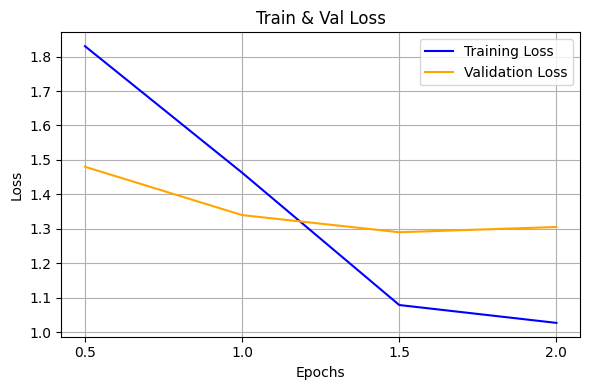

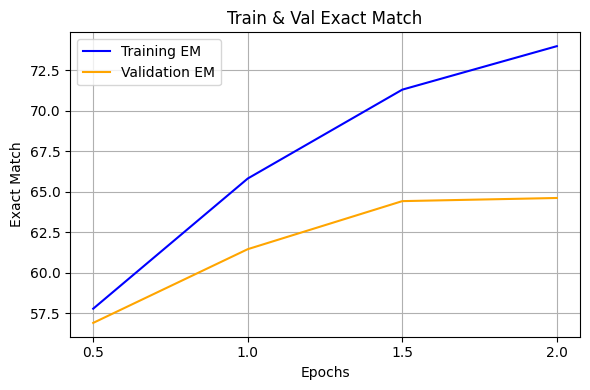

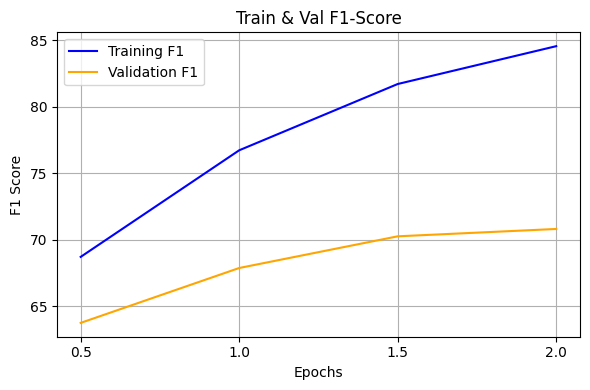

In [36]:
# Pastikan direktori output ada
os.makedirs(f"{output_dir}/plot", exist_ok=True)

# Ambil data dari history
epochs = training_history['epochs']
train_loss = training_history['train_loss']
val_loss = training_history['val_loss']
train_em = [m['exact'] for m in training_history['train_metrics']]
val_em = [m['exact'] for m in training_history['val_metrics']]
train_f1 = [m['f1'] for m in training_history['train_metrics']]
val_f1 = [m['f1'] for m in training_history['val_metrics']]

xticks_custom = [0.5, 1, 1.5, 2]

# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='orange', label='Validation Loss')
plt.title('Train & Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(xticks_custom)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/plot/loss.png")
plt.show()

# Plot Exact Match
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_em, color='blue', label='Training EM')
plt.plot(epochs, val_em, color='orange', label='Validation EM')
plt.title('Train & Val Exact Match')
plt.xlabel('Epochs')
plt.ylabel('Exact Match')
plt.xticks(xticks_custom)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/plot/exact_match.png")
plt.show()

# Plot F1 Score
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_f1, color='blue', label='Training F1')
plt.plot(epochs, val_f1, color='orange', label='Validation F1')
plt.title('Train & Val F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(xticks_custom)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/plot/f1_score.png")
plt.show()

# Evaluation

In [37]:
trained_model = AutoModelForQuestionAnswering.from_pretrained(output_dir)
trained_model.to(accelerator.device)

# Memuat dataset test
test_dataset = datasets['test']

# Preprocessing test dataset
test_features = test_dataset.map(
    preprocess_examples,
    batched=True,
    remove_columns=test_dataset.column_names,
    fn_kwargs = {
        'tokenizer':tokenizer,
        'is_test':True,
    }
)

test_eval_dataset_for_model = test_features.remove_columns(["example_id", "offset_mapping"])
test_eval_dataset_for_model.set_format("torch")

test_dataloader = DataLoader(
    test_eval_dataset_for_model,
    shuffle=False,
    collate_fn=default_data_collator,
    batch_size=batch_size
)

test_dataloader = accelerator.prepare_data_loader(test_dataloader)

# Evaluasi model tanpa menghitung loss
def evaluate_model_loaded(model, dataloader, features_dataset, raw_dataset, desc="Evaluating"):
    model.eval()
    start_logits = []
    end_logits = []
    
    for batch in tqdm(dataloader, desc=desc, leave=False):
        with torch.no_grad():
            outputs = model(**batch)
        
        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())
    
    start_logits = np.concatenate(start_logits)[:len(features_dataset)]
    end_logits = np.concatenate(end_logits)[:len(features_dataset)]
    
    metrics = compute_metrics(start_logits, end_logits, features_dataset, raw_dataset)
    return metrics

# Evaluasi model pada dataset test
test_metrics = evaluate_model_loaded(
    trained_model,
    test_dataloader,
    test_features,
    test_dataset,
    desc="Evaluating Test Dataset"
)

# Tampilkan hasil evaluasi
print("\nHasil Evaluasi Model pada Dataset Test:")
print(f"  Test Exact Match: {test_metrics['exact']:.2f}")
print(f"  Test F1 Score: {test_metrics['f1']:.2f}")

Map:   0%|          | 0/13032 [00:00<?, ? examples/s]

Evaluating Test Dataset:   0%|          | 0/821 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]


Hasil Evaluasi Model pada Dataset Test:
  Test Exact Match: 60.57
  Test F1 Score: 70.84


# Prediction

In [38]:
from transformers import pipeline

# Inisialisasi pipeline untuk Question Answering
qa_pipeline = pipeline("question-answering", model=f"/kaggle/working/{output_dir}")

# Contoh konteks dan pertanyaan
context = """
Proklamasi Kemerdekaan Indonesia terjadi pada 17 Agustus 1945. Teks proklamasi dibacakan oleh Soekarno di kediamannya di Jalan Pegangsaan Timur No. 56, Jakarta. Proklamasi ini menandai berakhirnya penjajahan di Indonesia dan awal berdirinya negara Indonesia yang merdeka.
"""

question = "Kapan proklamasi kemerdekaan terjadi?"

# Melakukan prediksi
result = qa_pipeline(question=question, context=context)

# Menampilkan hasil
print("Pertanyaan:", question)
print("Jawaban:", result['answer'])
print("Confidence Score:", result['score'])

Device set to use cuda:0


Pertanyaan: Kapan proklamasi kemerdekaan terjadi?
Jawaban: 17 Agustus 1945
Confidence Score: 0.9532157778739929


In [39]:
# Contoh konteks dan pertanyaan
context = """
Proklamasi Kemerdekaan Indonesia terjadi pada 17 Agustus 1945. Teks proklamasi dibacakan oleh Soekarno di kediamannya di Jalan Pegangsaan Timur No. 56, Jakarta. Proklamasi ini menandai berakhirnya penjajahan di Indonesia dan awal berdirinya negara Indonesia yang merdeka.
"""

question = "Apa itu galaksi bimasakti?"

# Melakukan prediksi
result = qa_pipeline(question=question, context=context, handle_impossible_answer=True)

# Menampilkan hasil
print("Pertanyaan:", question)
print("Jawaban:", result['answer'])
print("Confidence Score:", result['score'])

Pertanyaan: Apa itu galaksi bimasakti?
Jawaban: Indonesia
Confidence Score: 0.0024658916518092155


# Download Model

In [40]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [ ]:
zip_dir()